# Neural Network Classifier for Accenture Dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time

## Load data

In [4]:
data_path = '../datathonfme2022/accenture_challenge/datathon_SC_ACN_22'

orders_df = pd.read_csv(f'{data_path}/orders.csv', sep=';', na_filter=False)

# basic cleaning (remove duplicate ports)
def remove_port_duplicates(port):
    if port=='BCN':
        return 'Barcelona'
    if port=='ATHENAS':
        return 'Athens'
    return port
orders_df['origin_port'] = orders_df['origin_port'].map(remove_port_duplicates)

orders_df.head()
len(orders_df.loc[orders_df.late_order==True]) / len(orders_df)

0.23763519899191432

In [5]:
cities_df = pd.read_csv(f'{data_path}/cities_data.csv', sep=';')
cities_df.head()

,city_from_name,city_to_name,city_from_coord,city_to_coord,distance
0,Dusseldorf,Zaragoza,"(51.2254018, 6.7763137)","(41.6521342, -0.8809428)",1214.4772
1,Dusseldorf,Venlo,"(51.2254018, 6.7763137)","(51.39244885, 6.1511724144122955)",47.3876
2,Dusseldorf,Bratislava,"(51.2254018, 6.7763137)","(48.1516988, 17.1093063)",819.2894
3,Dusseldorf,Hamburg,"(51.2254018, 6.7763137)","(53.550341, 10.000654)",339.2215
4,Dusseldorf,Rome,"(51.2254018, 6.7763137)","(41.8933203, 12.4829321)",1125.0290


In [6]:
products_df = pd.read_csv(f'{data_path}/product_attributes.csv', sep=',')
products_df.head()

,product_id,weight,material_handling
0,1672707,2876,3
1,1694456,2785,5
2,1682865,2751,3
3,1689146,2736,0
4,1664069,2707,4


## Feature Creation

### Fit one-hot encoders for every feature
Categorical features: origin_port, 3pl, customs_procedures, logistic_hub, customer, product_id, late_order
Numerical features: units

In [7]:
categorical_features = ['origin_port', '3pl', 'customs_procedures', 'logistic_hub', 'customer'] #, 'product_id']
numerical_features = ['units']

one_hot_encoders = {}

for feature in categorical_features:
    encoder = preprocessing.OneHotEncoder()
    feature_vals = np.array(orders_df[feature].drop_duplicates()).reshape(-1, 1)
    encoder.fit(feature_vals)
    one_hot_encoders[f'{feature}'] = encoder

one_hot_encoders

{'origin_port': OneHotEncoder(),
 '3pl': OneHotEncoder(),
 'customs_procedures': OneHotEncoder(),
 'logistic_hub': OneHotEncoder(),
 'customer': OneHotEncoder()}

### Numerical features MinMax Scaling

In [8]:
min_max_scalers = {}

for feature in numerical_features:
    scaler = preprocessing.MinMaxScaler()
    feature_vals = np.array(orders_df[feature]).reshape(-1, 1)
    scaler.fit(feature_vals)
    min_max_scalers[f'{feature}'] = scaler


min_max_scalers

{'units': MinMaxScaler()}

In [9]:
def transform_data_point(x: pd.Series):
    vec = np.array([])
    for feature, value in x.items():
        if feature in categorical_features:
            transformed_val = one_hot_encoders[feature].transform([[value]]).todense()
            vec = np.append(vec, np.array(transformed_val))
        elif feature in numerical_features:
            transformed_val = min_max_scalers[feature].transform([[value]])
            vec = np.append(vec, [transformed_val])
    vec = vec.reshape((1, -1))
    tensor = torch.tensor(vec, dtype=torch.float32)
    return tensor

In [10]:
t = transform_data_point(orders_df.iloc[1])
nin = t.shape[1]
nin

49

## Neural Network Architecture

In [11]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(nin, 25),
            nn.ReLU(),
            #nn.Linear(100, 50),
            #nn.ReLU(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [12]:
model = MLP()

In [13]:
for idx in range(100):
    t = transform_data_point(orders_df.iloc[idx])
    # print(model.forward(t))

## Create custom dataset

In [14]:
class AccentureDataset(Dataset):
    def __init__(self, orders_df):
        self.orders_df = orders_df

    def __len__(self):
        return len(self.orders_df)

    def __getitem__(self, idx):
        encoding = transform_data_point(orders_df.iloc[idx])
        label = float(orders_df['late_order'].iloc[idx])
        return encoding, label

## Trainer

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.BCELoss()

In [33]:
dataset = AccentureDataset(orders_df)
train_size = 20 #int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

In [34]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=True)

<IPython.core.display.Javascript object>


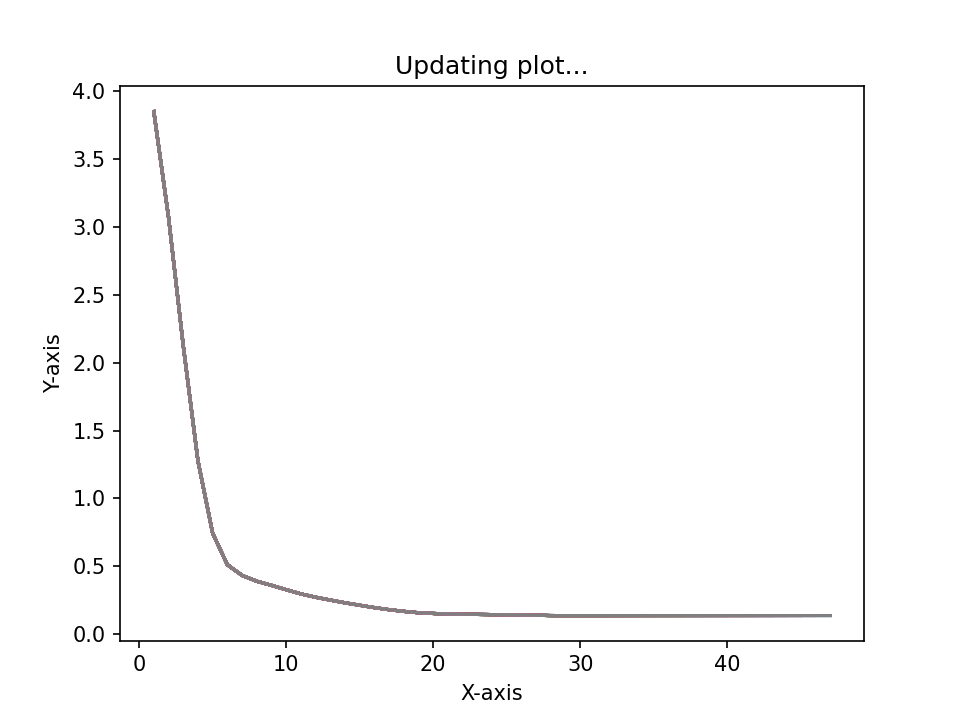

Starting training epoch 1
0 / 20
Evaluation for epoch 1
74.28385416666667
Starting training epoch 2
0 / 20
Evaluation for epoch 2
70.703125
Starting training epoch 3
0 / 20
Evaluation for epoch 3
67.96875
Starting training epoch 4
0 / 20
Evaluation for epoch 4
65.625
Starting training epoch 5
0 / 20
Evaluation for epoch 5
61.263020833333336
Starting training epoch 6
0 / 20
Evaluation for epoch 6
57.552083333333336
Starting training epoch 7
0 / 20
Evaluation for epoch 7
58.984375
Starting training epoch 8
0 / 20
Evaluation for epoch 8
55.013020833333336
Starting training epoch 9
0 / 20
Evaluation for epoch 9
59.375
Starting training epoch 10
0 / 20
Evaluation for epoch 10
60.807291666666664
Starting training epoch 11
0 / 20
Evaluation for epoch 11
59.635416666666664
Starting training epoch 12
0 / 20
Evaluation for epoch 12
64.84375
Starting training epoch 13
0 / 20
Evaluation for epoch 13
63.28125
Starting training epoch 14
0 / 20
Evaluation for epoch 14
64.58333333333333
Starting train

KeyboardInterrupt: 

In [35]:
%matplotlib notebook

num_epochs = 2000
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []

x, y = [], [] # plot epochs & accuracies
# enable interactive mode
plt.ion()
 
# creating subplot and figure
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y)
 
# setting labels
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Updating plot...")

for epoch in range(1, num_epochs+1):
    model.train()
    train_losses = []
    print(f'Starting training epoch {epoch}')
    
    for i, (X, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        outputs = model(X)
        labels = labels.reshape((-1, 1))
        labels = labels.to(torch.float32)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / {train_size}')
            
        if i > 10:
            break
          
            
    if epoch%1 == 0:
        x.append(epoch)
        y.append(loss.item())
        #print(outputs[:8], '\n', labels[:8])
        #print(x, y)
        line1.set_xdata(x)
        line1.set_ydata(y)
        # re-drawing the figure
        fig.canvas.draw()

        # to flush the GUI events
        fig.canvas.flush_events()
        plt.plot(x, y)
        time.sleep(0.1)
        
    # torch.save(model, 'model_lr001.pt')
    
    # continue
    print(f'Evaluation for epoch {epoch}')
    model.eval()
    valid_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (X, labels) in enumerate(valid_loader):
            outputs = model(X)
            labels = labels.reshape((-1, 1))
            labels = labels.to(torch.float32)
            
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            predicted = outputs >= 0.5 
            predicted = predicted.reshape((-1, 1)).to(torch.float32)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            if i>10:
                break
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    print(accuracy)
    valid_acc_list.append(accuracy)
        
valid_acc_list